In [1]:
# first make sure the input data are good 
import numpy as np 
import os 
import sys
from scipy.stats import zscore
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, make_scorer, f1_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_validate, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import shap
from scipy import stats
if sys.platform == 'darwin':
    print("Current system is macOS")
    main_fold_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction'
elif sys.platform == 'linux':
    print("Current system is Ubuntu")
    main_fold_path = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning'
else:
    print("Current system is neither macOS nor Ubuntu")
    
sys.path.append(main_fold_path)    
os.chdir(main_fold_path)
from utils.hyperopt_utils import get_best_hyperparameters, get_best_hyperparameters_skf_inside_loocv_monitoring_recall_bacc
from utils.fnirs_utils import print_md_table_val_test_AUC

from scripts.fusion_model.fusion_model_utils import derive_average_MMDR_score
from scripts.fusion_model.fusion_model_utils import replace_nan_with_mean
from scripts.fusion_model.fusion_model_utils import impute_nan_data
from scripts.fusion_model.fusion_model_utils import process_with_nan_using_imputation_zscore
from scripts.fusion_model.fusion_model_utils import read_base_T2_SDS_CGI 
from scripts.fusion_model.fusion_model_utils import read_pychiatry
from scripts.fusion_model.fusion_model_utils import read_HAMD_score
from scripts.fusion_model.fusion_model_utils import read_demographic
from scripts.fusion_model.fusion_model_utils import plot_avg_auc
from scripts.fusion_model.fusion_model_utils import train_xgboost_shuffle_feature 
from scripts.fusion_model.fusion_model_utils import save_shap
from scripts.fusion_model.fusion_model_utils import read_dose_information
import time


import time
start_time = time.time()

K_FOLD = 5
fold_path = 'allData/prognosis_mix_hb/pretreatment_response'
MMDR_path = 'allData/prognosis_mix_hb/pretreatment_response/MDDR/MDDR_derived_from_load_evaluate.npy'

base_T2_SDS_CGI = read_base_T2_SDS_CGI(fold_path)
pyschiatry = read_pychiatry(fold_path)
HAMD_score = read_HAMD_score(fold_path)
demographic = read_demographic(fold_path)
dose = read_dose_information(fold_path)



pro_base_T2_SDS_CGI = process_with_nan_using_imputation_zscore(base_T2_SDS_CGI)
pro_pyschiatry = process_with_nan_using_imputation_zscore(pyschiatry)
pro_pyschiatry = np.concatenate((pro_pyschiatry[:, :-3], pro_pyschiatry[:, -2:]), axis=1) # must remove the -3rd column, because its existen will cause nan value of that column which is On antidpressant(s) ONLY
# pro_pyschiatry = np.concatenate((pro_pyschiatry[:, :1], pro_pyschiatry[:, 2:]), axis=1) # delete Current psychiatric comorbidities — Binary because already have Current psychiatric comorbidities — Coded
pro_HAMD_score = process_with_nan_using_imputation_zscore(HAMD_score)
pro_demographic = process_with_nan_using_imputation_zscore(demographic)
pro_dose = process_with_nan_using_imputation_zscore(dose)


Current system is Ubuntu


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [2]:
pro_pyschiatry.shape

(64, 12)

In [5]:
print("pro_base_T2_SDS_CGI.shape: ", pro_base_T2_SDS_CGI.shape)

pro_base_T2_SDS_CGI.shape:  (64, 14)


In [ ]:
print(HAMD_score)

In [1]:

# # show dose information 
# fig, axs = plt.subplots(1, 2, figsize=(8, 12))
# img1 = axs[0].imshow(dose)
# img2 = axs[1].imshow(pro_dose)
# for ax in axs:
#     ax.set_aspect('auto')

# cbar1 = fig.colorbar(img1, ax=axs[0])  # Add color bar for the first image
# cbar2 = fig.colorbar(img2, ax=axs[1])  # Add color bar for the second image

# plt.show()

# for i in range(dose.shape[0]):
#     print(f'dose -> {dose[i]}')
#     print(f'process -> {pro_dose[i]}')

# for i in range(pro_dose.shape[-1]):
#     plt.figure()
#     plt.title(f'dose {i}')
#     plt.plot(pro_dose[:, i])

In [7]:
np.save(f'{fold_path}/MDDR/nor_T2_SDS_CGI.npy', pro_base_T2_SDS_CGI)

In [6]:
nor_demo_cli_merge_data = np.concatenate((pro_pyschiatry[:, :9], pro_demographic, pro_dose[:, 1:2], pro_HAMD_score[:, :1]), axis=1)
print(nor_demo_cli_merge_data.shape)
# print(f'{fold_path}/nor_demo_cli_merge_data.npy')
np.save(f'{fold_path}/nor_demo_cli_merge_data.npy', nor_demo_cli_merge_data)
# X_data = np.concatenate((pro_pyschiatry[:, :9], pro_demographic, fnirs_feature), axis=1)


(64, 18)


In [13]:
fnirs_feature = []

for i in range(10):
    individual_fnirs_feature =  np.load(MMDR_path)[i, :, :] # np.load(MMDR_path) #
    # fnirs_feature = np.mean(fnirs_feature, axis=(0)) # [:, 1:]
    # individual_fnirs_feature = individual_fnirs_feature.argmax(axis=1)[:, np.newaxis]
    individual_fnirs_feature = individual_fnirs_feature[..., 1:]
    fnirs_feature.append(individual_fnirs_feature)
fnirs_feature = np.array(fnirs_feature)
fnirs_feature = np.squeeze(fnirs_feature)
fnirs_feature = np.transpose(fnirs_feature, (1,0))
print(fnirs_feature.shape)
merge_data = fnirs_feature#np.concatenate((pro_pyschiatry[:, :9], pro_demographic, pro_dose[:, 1:2], fnirs_feature), axis=1)
np.save(f'{fold_path}/merge_psychiatry_demo_dose_data.npy', merge_data)

(64, 10)


: 

In [12]:




# fnirs_feature = derive_average_MMDR_score(MMDR_path, K_FOLD=K_FOLD)

Y = np.load(fold_path + '/label.npy', allow_pickle=True)

# repeat to see if seed is working 
data_name = 'dose_metrics'
X_data = merge_data # merge_data # fnirs_feature # merge_data # np.concatenate((pro_pyschiatry[:, :9], pro_demographic, pro_dose, fnirs_feature), axis=1)
# X_data = np.concatenate((pro_pyschiatry[:, :9], pro_demographic, fnirs_feature), axis=1)

best_params_xgboost = {'alpha': 0.8984148424903339, 'gamma': 0.03882220445979434, 'lambda': 0.6753800395275018, 'learning_rate': 0.23017037995236783, 'max_depth': 10, 'min_child_weight': 1.7961639148503241, 'n_estimators': 117, 'scale_pos_weight': 1000} #69215400.51817685}

shuffle_all_shaps = train_xgboost_shuffle_feature(X_data, 
                                                  Y, 
                                                  model_name='CatBoost',
                                                  num_shuffle=10,  #10
                                                  random_seed=1025,
                                                  title=f"Treatment Response Prediction (fNIRS + demographic and psychiatric feature) ", 
                                                  is_plotting_avg_auc=True, 
                                                  is_shuffling=True, 
                                                  is_computing_shap=False,
                                                  best_params_xgboost=None,
                                                  num_evals=2,#150
                                                  loocv_metrics_save_file_name= data_name + '.npy')
# save_shap(shuffle_all_shaps, X_data, output_fold='results/SHAP', name='shap_values_'+data_name+'.npy')

# End timing
end_time = time.time()

# Calculate total time taken
total_time = end_time - start_time
print(f"The program took {total_time} seconds to run.")


 shuffled_indices  [ 8  3  5 20  4 11 13  1 23 10  0  7 26  6 19  2 15 24 22 17 25 16 14 12
 18 21  9]
100%|██████████| 2/2 [00:15<00:00,  7.94s/trial, best loss: -0.6034374360155611]
Best hyperparameters: {'alpha': 2.037765727038418, 'gamma': 2.8117926933894326, 'lambda': 3.9315024527920452, 'learning_rate': 0.04519061934923958, 'max_depth': 4, 'min_child_weight': 1.6984737187867398, 'n_estimators': 170, 'scale_pos_weight': 8.672532325068804}


KeyboardInterrupt: 

: 

In [5]:
# get the best parameters only once for good 
# best_params_xgboost = get_best_hyperparameters_skf_inside_loocv_monitoring_recall_bacc(X_data, Y, num_evals=200, random_seed=1025)
best_params_xgboost = {'alpha': 0.8984148424903339, 'gamma': 0.03882220445979434, 'lambda': 0.6753800395275018, 'learning_rate': 0.23017037995236783, 'max_depth': 10, 'min_child_weight': 1.7961639148503241, 'n_estimators': 117, 'scale_pos_weight': 69215400.51817685}
# get_best_hyperparameters_skf_inside_loocv_monitoring_recall_bacc

 shuffled_indices  [ 7 12  0  3 10  8 13 16  6  4 14  9  5  1  2 15 11]
num_of_shuffle 0 scaled by 1000000.0 Accuracy: 0.40625 Sensitivity is 0.7857142857142857 Specificity is 0.3 AUC is 0.6785714285714285
[0.55895833 0.80885417 0.3090625  0.65560764]
 shuffled_indices  [ 6  1  2 16  5 10 14 15  7  4  8  3 13  0  9 11 12]
num_of_shuffle 1 scaled by 1000000.0 Accuracy: 0.359375 Sensitivity is 0.7857142857142857 Specificity is 0.24 AUC is 0.5871428571428572
[0.55473958 0.79479167 0.3146875  0.65018519]
 shuffled_indices  [10 12  3 14  7  0  4  6  2  5 11  9 16  8  1 15 13]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


num_of_shuffle 2 scaled by 1000000.0 Accuracy: 0.4375 Sensitivity is 0.8571428571428571 Specificity is 0.32 AUC is 0.7128571428571429
[0.56286458 0.80989583 0.31583333 0.63923322]


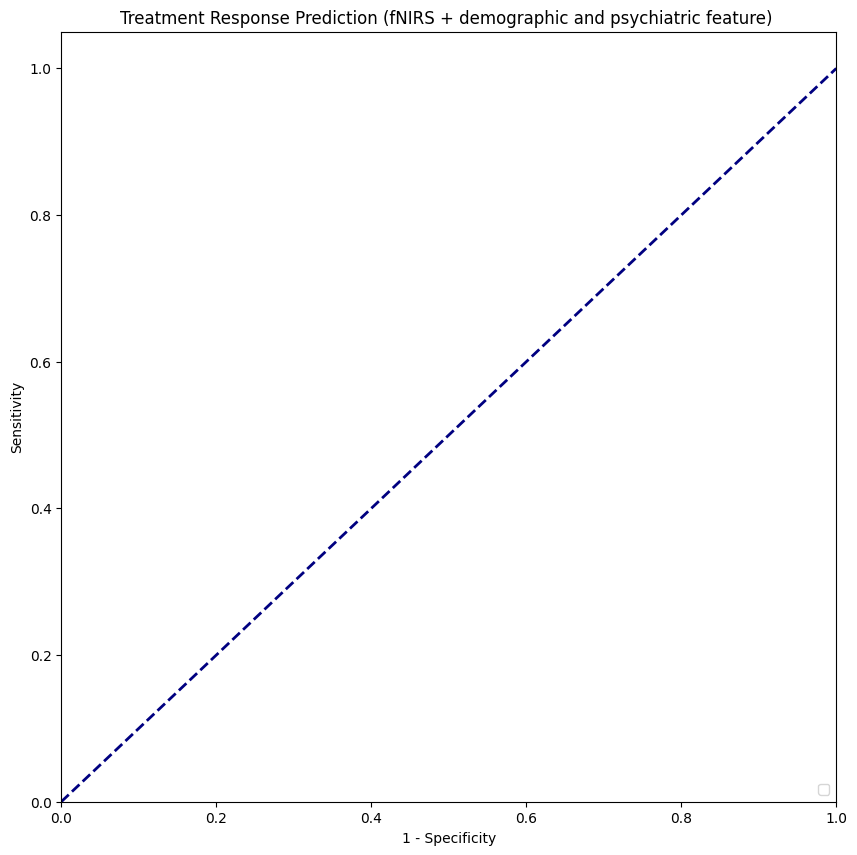

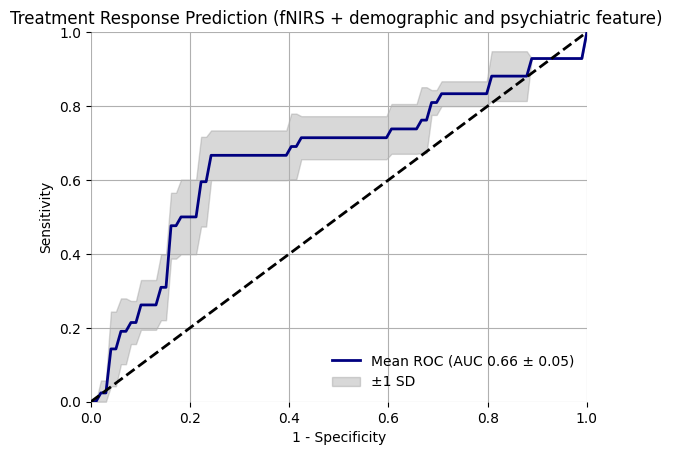

| Model Name | Testing Set |             |             |             | Validation Set |             |             |             |
|------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|
|            | Balanced Accuracy | Sensitivity | Specificity | AUC | Balanced Accuracy | Sensitivity | Specificity | AUC |
| Mean XGBoost   | 54.8095  | 80.9524  | 28.6667  | 65.9524  | 55.8854  | 80.4514  | 31.3194  | 64.8342  |
| SD XGBoost   | 3.1131  | 3.3672  | 3.3993  | 5.3061  | 0.3318  | 0.6888  | 0.2959  | 0.6811  |
The program took 22830.859189987183 seconds to run.


In [ ]:
start_time = time.time()
# repeat to see if seed is working 
data_name = 'fNIRS_demo_his_metrics'
X_data = np.concatenate((pro_pyschiatry[:,:9], pro_demographic, fnirs_feature), axis=1)

shuffle_all_shaps = train_xgboost_shuffle_feature(X_data, 
                                                  Y, 
                                                  model_name='XGBoost',
                                                  num_shuffle=3, 
                                                  random_seed=1024,
                                                  title=f"Treatment Response Prediction (fNIRS + demographic and psychiatric feature) ", 
                                                  is_plotting_avg_auc=True, 
                                                  is_shuffling=True, 
                                                  is_computing_shap=True,
                                                  best_params_xgboost=True,
                                                  num_evals=2,
                                                  loocv_metrics_save_file_name= data_name + '.npy')

save_shap(shuffle_all_shaps, X_data, output_fold='results/SHAP', name='shap_values_'+data_name+'.npy')

# End timing
end_time = time.time()

# Calculate total time taken
total_time = end_time - start_time
print(f"The program took {total_time} seconds to run.")

In [ ]:
# Retrieve the fprs, tprs, and aucs to plot it out

import numpy as np
metrics = np.load('results/fNIRS_demo_his_metrics.npy', allow_pickle=True).item()
fprs, tprs, roc_aucs = metrics['fprs'], metrics['tprs'], metrics['roc_aucs']
plot_avg_auc(fprs, tprs, roc_aucs, 'Hello world')

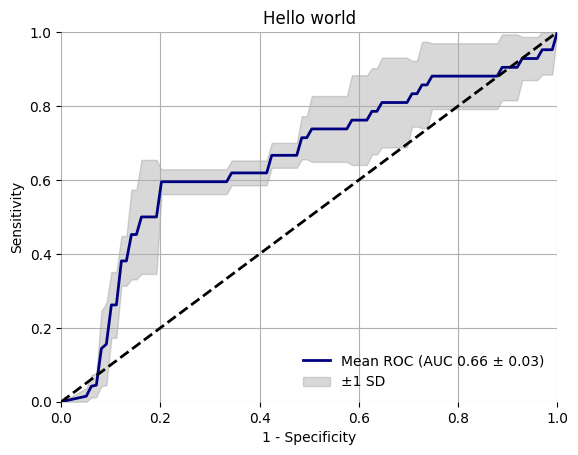

In [ ]:
from hyperopt import space_eval
from hyperopt import hp
# for i in range(pro_pyschiatry.shape[1]):
X_data = np.concatenate((pro_pyschiatry[:,:9], pro_demographic, fnirs_feature), axis=1)

# X_data = fnirs_feature
shuffle_all_shaps = train_xgboost_shuffle_feature(X_data, 
                                                  Y, 
                                                  model_name='XGBoost',
                                                  num_shuffle=10, 
                                                  random_seed=1024,
                                                  title=f"Treatment Response Prediction (fNIRS + demographic and psychiatric feature) ", 
                                                  is_plotting_avg_auc=True, 
                                                  is_shuffling=True, 
                                                  is_computing_shap=False,
                                                  best_params_xgboost=True,
                                                  num_evals=10)


In [11]:
for i in range(4,14):
    fnirs_feature = np.mean(np.load(MMDR_path + f'/y_pred_loocv_v{i}.npy').reshape(-1, K_FOLD, 2), axis=1)[:, 1:]
    # for i in range(pro_pyschiatry.shape[1]):
    X_data = np.concatenate((pro_pyschiatry[:,:9], pro_demographic, fnirs_feature), axis=1)
    np.save('/Users/shanxiafeng/Documents/Code/learning/learn_hypderopt/input/data_{}.npy'.format(i-3), X_data)
    # X_data = fnirs_feature
    # shuffle_all_shaps = train_xgboost_shuffle_feature(X_data, Y, model_name='XGBoost', num_shuffle=10, title=f"(I={i-3})Treatment Response Prediction (fNIRS + demographic and psychiatric feature) ", is_plotting_avg_auc=False, is_shuffling=False, is_computing_shap=False)


Correlation coefficient (r): -0.2284404756062832
P-value: 0.06943263932219333


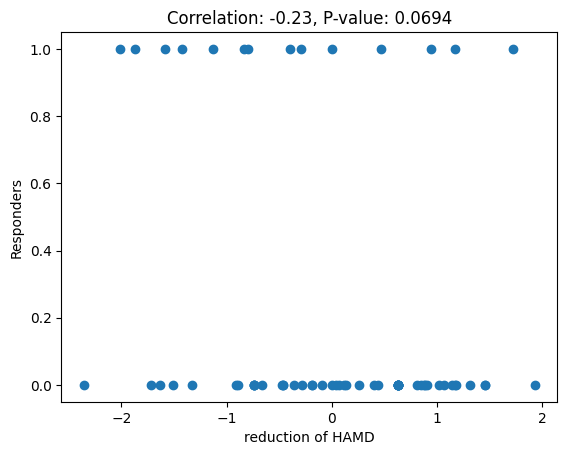

In [35]:
plt.figure()
untreated_month = data[:, i]

correlation, p_value = pearsonr(pro_HAMD_score[:,2], Y)
print("Correlation coefficient (r):", correlation)
print("P-value:", p_value)

plt.scatter(pro_HAMD_score[:,2], Y)
plt.title(f"Correlation: {correlation:.2f}, P-value: {p_value:.4f}")
plt.xlabel("reduction of HAMD")
plt.ylabel("Responders")
plt.show()


In [ ]:
import numpy as np
reduction = HAMD_score[:, 2] 

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

psychiatric_history_name = ['Past trauma', 
                        'Current psychiatric comorbidities', 
                        'Current psychiatric comorbidities',
                        'Family history of psychiatric illness',
                        'Age of depression onset (years)',
                        'Duration of depression (years)',
                        'Duration of untreated depression (months)',
                        'Past EmD visit(s) because of depression',
                        'Type of episode']
demographic_name = ['Age', 'Gender', 'Ethnicity', 'Handedness', 'Education years', 'Education level', 'Perceived social support']
fnirs_name = ['MDDR']


data = pro_demographic
name = demographic_name 
for i in range(data.shape[1]):
    plt.figure()
    untreated_month = data[:, i]

    correlation, p_value = pearsonr(untreated_month, reduction)
    print("Correlation coefficient (r):", correlation)
    print("P-value:", p_value)

    plt.scatter(untreated_month, reduction)
    plt.title(f"Correlation: {correlation:.2f}, P-value: {p_value:.4f}, name: {name[i]}")
    plt.xlabel("Untreated Month")
    plt.ylabel("HAMD Reduction")
    plt.show()



In [ ]:
import shap
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)
print(X_display)

In [451]:

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

# Create a scorer for specificity
specificity_scorer = make_scorer(specificity_score)

X_train = X_data[:, -1:]
Y_train = Y
models = {
    #'CatBoost': CatBoostClassifier(scale_pos_weight=12, verbose=0),
    'XGBoost': XGBClassifier(scale_pos_weight=61 * 1e5),
    'RandomForest': RandomForestClassifier(n_estimators=200, bootstrap=False, min_samples_leaf=10, class_weight='balanced', max_depth=20),
    'DecisionTree': DecisionTreeClassifier(max_depth=190, criterion='log_loss', splitter='random', class_weight="balanced"),
    'Support Vector': SVC(kernel='linear', probability=False, class_weight={0:1, 1:61e5}, C=1e4),
    'NearestNeighbor': KNeighborsClassifier(),
    'Perceptron': Perceptron()
}


results = {}

for model_name, model in models.items():
    # Define the scorers you want to use
    scoring = {'balanced_accuracy': make_scorer(balanced_accuracy_score),
               'sensitivity': make_scorer(recall_score),
                'specificity': specificity_scorer}
    
    # Perform 5-fold cross-validation and get the results
    cv_results = cross_validate(model, X_train, Y_train, cv=5, scoring=scoring, return_train_score=False)
    
    # Calculate mean scores
    mean_accuracy = cv_results['test_balanced_accuracy'].mean()
    mean_sensitivity = cv_results['test_sensitivity'].mean()
    mean_specificity = cv_results['test_specificity'].mean()
    
    # Store the results
    results[model_name] = {'bAcc': mean_accuracy, 'Sensitivity': mean_sensitivity, 'Specificity': mean_specificity}
    print(f"model - {model_name} - metrics - {results[model_name]}")

model - XGBoost - metrics - {'bAcc': 0.6566666666666666, 'Sensitivity': 0.7333333333333333, 'Specificity': 0.58}
model - RandomForest - metrics - {'bAcc': 0.6466666666666667, 'Sensitivity': 0.7333333333333333, 'Specificity': 0.5599999999999999}
model - DecisionTree - metrics - {'bAcc': 0.5533333333333335, 'Sensitivity': 0.36666666666666664, 'Specificity': 0.74}
model - Support Vector - metrics - {'bAcc': 0.5, 'Sensitivity': 1.0, 'Specificity': 0.0}
model - NearestNeighbor - metrics - {'bAcc': 0.5900000000000001, 'Sensitivity': 0.3, 'Specificity': 0.8800000000000001}
model - Perceptron - metrics - {'bAcc': 0.5333333333333333, 'Sensitivity': 0.26666666666666666, 'Specificity': 0.8}


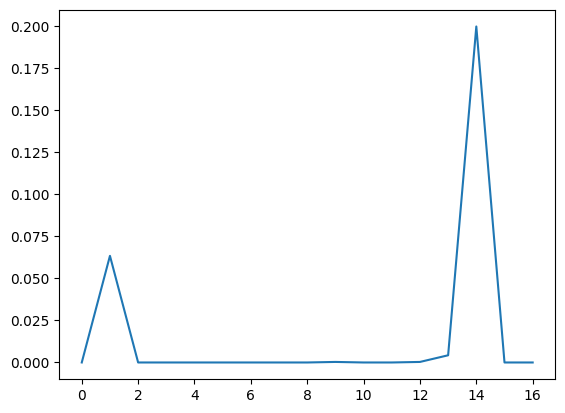

In [9]:
shap_values = []
shap_base_values = []
for i in range(1):
    for j in range(64):
            shap_v = []
            shap_b = []
            for k in range(17):  
                shap_v.append(shuffle_all_shaps[i][j][0][k].values)
                shap_b.append(shuffle_all_shaps[i][j][0][k].base_values)
            shap_values.append(shap_v)
            shap_base_values.append(shap_b)

shap_values = np.array(shap_values) / np.max(np.abs(shap_values))
shap_base_values = np.array(shap_base_values) 


minus_value = shap_values + shap_base_values  
# print(minus_value.shape)
plt.plot(np.mean(np.abs(shap_values), axis=0))

In [9]:
psychiatric_history_name = ['Past trauma', 
                        'Current psychiatric comorbidities', 
                        'Current psychiatric comorbidities',
                        'Family history of psychiatric illness',
                        'Age of depression onset (years)',
                        'Duration of depression (years)',
                        'Duration of untreated depression (months)',
                        'Past EmD visit(s) because of depression',
                        'Type of episode']
demographic_name = ['Age', 'Gender', 'Ethnicity', 'Handedness', 'Education years', 'Education level', 'Perceived social support']
fnirs_name = ['MDDR']


x_input_name = psychiatric_history_name + demographic_name + fnirs_name

print(len(x_input_name))

17


In [10]:
shap_values = shap_values / np.max(shap_values)

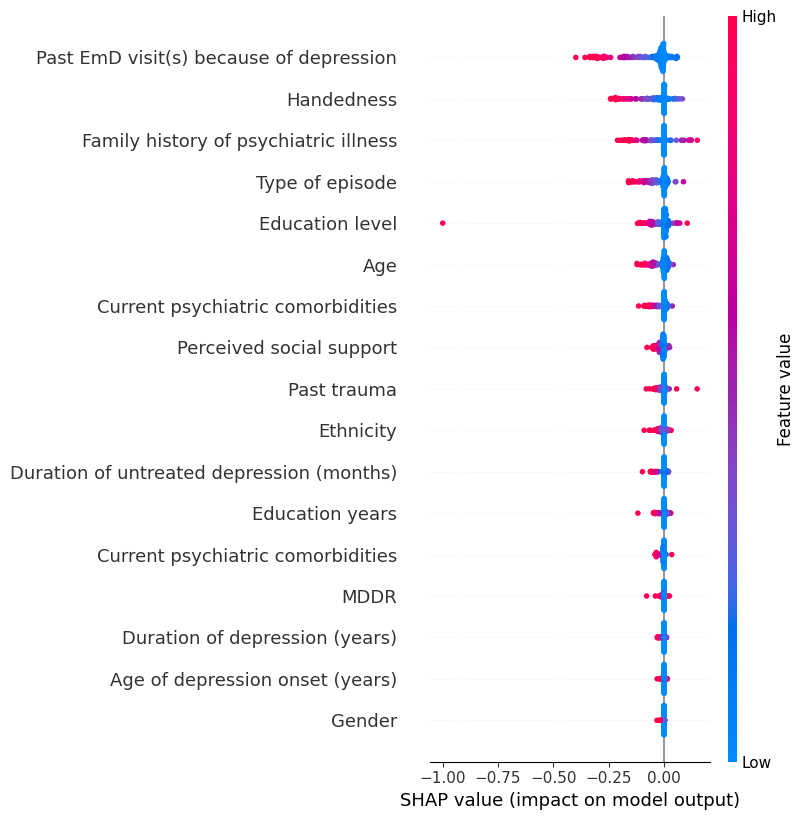

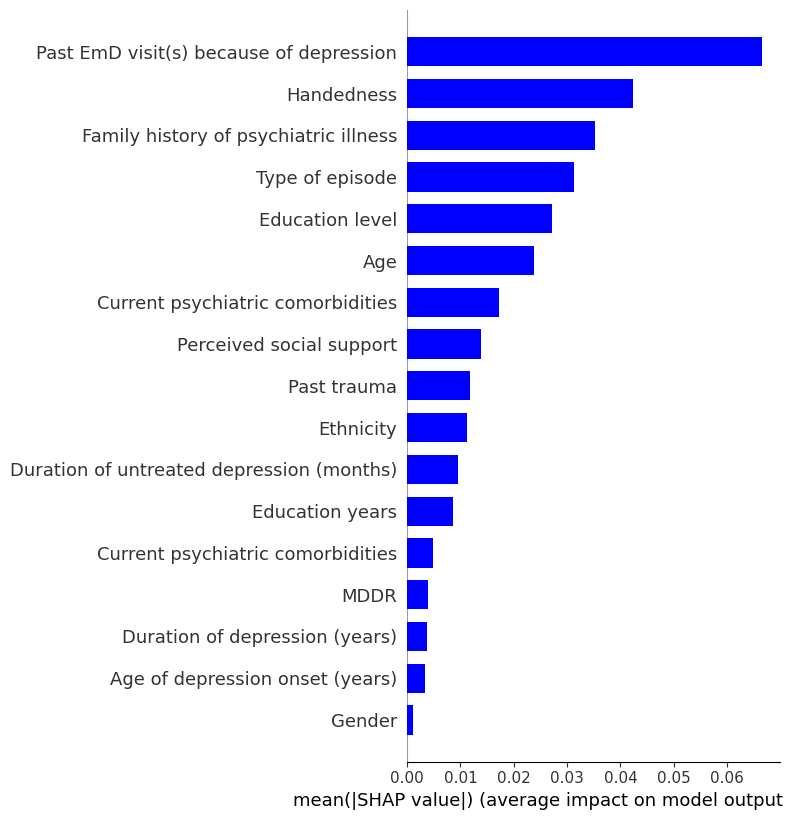

In [10]:
shap.summary_plot(shap_values, features=np.abs(shap_values), feature_names=x_input_name)
shap.summary_plot(shap_values, features=np.abs(shap_values), feature_names=x_input_name, plot_type='bar', color='blue')

# shap.plots.bar(shuffle_all_shaps[0][0][0])

In [38]:

np_shuffle_all_shaps = np.array(shuffle_all_shaps)

In [44]:
combined_shap_values = []
for i in range(64):
    combined_shap_values.append(shuffle_all_shaps[0][i][0].values)
combined_shap_values = np.array(combined_shap_values)    

base_values = shuffle_all_shaps[0][0][0].base_values
data = shuffle_all_shaps[0][0][0].data


In [304]:

# fnirs_prediction_all = fnirs_prediction_all[:, -1:]
# print(fnirs_prediction_all.shape)


<function auc at 0x13f134700>
<function auc at 0x13f134700>
<function auc at 0x13f134700>
[array([0.  , 0.02, 0.02, 0.04, 0.04, 0.24, 0.24, 0.36, 0.36, 0.82, 0.82,
       0.84, 0.84, 0.88, 0.88, 0.9 , 0.9 , 0.94, 0.94, 1.  ]), array([0.  , 0.  , 0.04, 0.04, 0.06, 0.06, 0.12, 0.12, 0.24, 0.24, 0.56,
       0.56, 0.76, 0.76, 0.78, 0.78, 0.82, 0.82, 1.  , 1.  ]), array([0.  , 0.02, 0.02, 0.06, 0.06, 0.08, 0.08, 0.1 , 0.1 , 0.14, 0.14,
       0.4 , 0.4 , 0.7 , 0.7 , 0.8 , 0.8 , 0.94, 0.94, 0.96, 0.96, 0.98,
       0.98, 1.  ])]


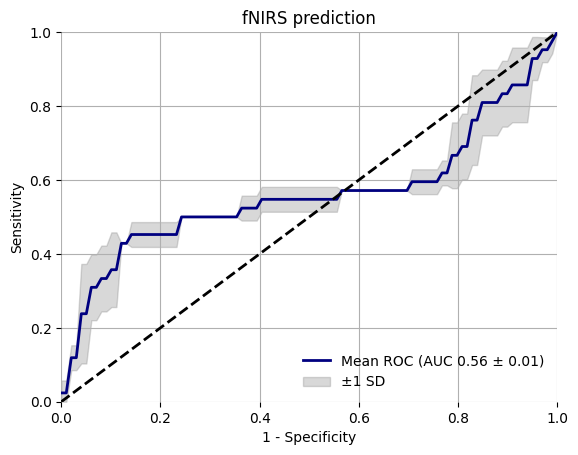

In [147]:
fprs, tprs, aucs = [], [], []
for i in range(3):
    y_pred = fnirs_prediction_all[:, i]
    fpr, tpr, _ = roc_curve(Y, y_pred)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    # plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % auc)
    print(auc)
    
print(fprs)

plot_avg_auc(fprs, tprs, aucs, 'fNIRS prediction')

In [1]:
print("Hello")

Hello


scaled by 1000000.0 Accuracy: 0.609375 Sensitivity is 0.5714285714285714 Specificity is 0.62 AUC is 0.6585714285714286
[0.69583333 0.69947917 0.6921875 ]
scaled by 1000000.0 Accuracy: 0.59375 Sensitivity is 0.5 Specificity is 0.62 AUC is 0.6542857142857142
[0.68329861 0.69166667 0.67493056]
scaled by 1000000.0 Accuracy: 0.609375 Sensitivity is 0.5 Specificity is 0.64 AUC is 0.6642857142857143
[0.69039931 0.70416667 0.67663194]
scaled by 1000000.0 Accuracy: 0.59375 Sensitivity is 0.5 Specificity is 0.62 AUC is 0.6614285714285715
[0.68909722 0.69791667 0.68027778]
scaled by 1000000.0 Accuracy: 0.625 Sensitivity is 0.5 Specificity is 0.66 AUC is 0.6585714285714286
[0.69578125 0.7        0.6915625 ]
scaled by 1000000.0 Accuracy: 0.59375 Sensitivity is 0.5 Specificity is 0.62 AUC is 0.6642857142857143
[0.68491319 0.69479167 0.67503472]
scaled by 1000000.0 Accuracy: 0.625 Sensitivity is 0.5714285714285714 Specificity is 0.64 AUC is 0.6628571428571428
[0.69770833 0.70260417 0.6928125 ]
scaled

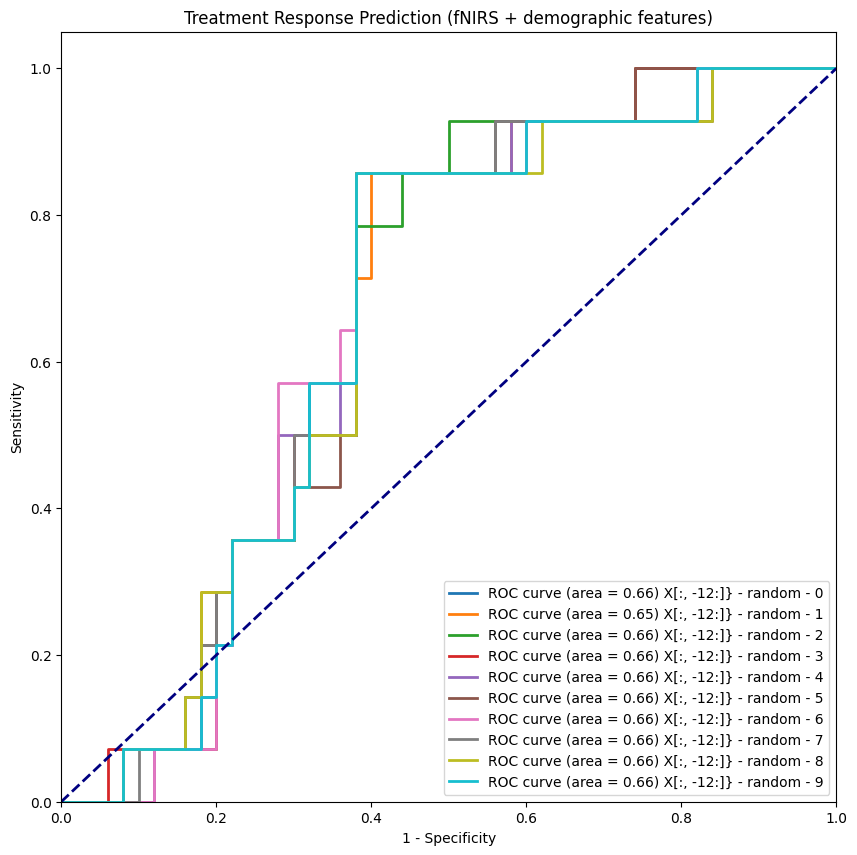

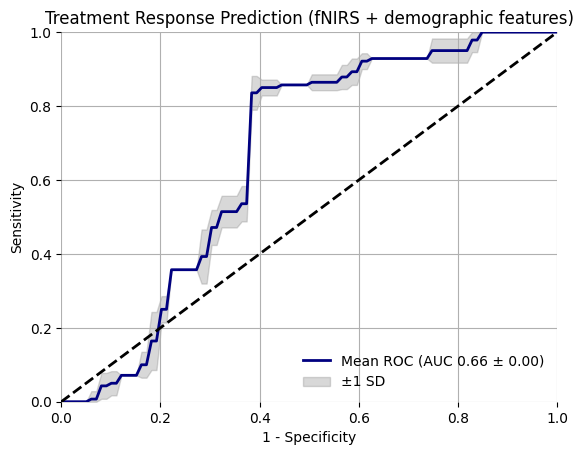

In [ ]:
acc = train_xgboost_shuffle_feature(X_data, Y, num_shuffle=10, title="Treatment Response Prediction (fNIRS + demographic features)", is_plotting_avg_auc=True)


In [5]:


mean_clinical_data = replace_nan_with_mean(clinical_data)
imputed_clinical_data = impute_nan_data(clinical_data)
z_imputed_clinical_data = zscore(imputed_clinical_data, axis=0)

# add MMDT data

demographic_data = demographic_data.astype(float)
demographic_data = impute_nan_data(demographic_data)
demographic_data = zscore(demographic_data, axis=0)

In [27]:

# plt.figure()
# plt.imshow(pro_base_T2_SDS_CGI, aspect='auto')
# plt.figure()
# plt.imshow(pro_pyschiatry, aspect='auto')
# plt.figure()
# plt.imshow(pro_HAMD_score, aspect='auto')
# plt.figure()
# plt.imshow(pro_demographic, aspect='auto')




clinical_data = np.concatenate((pro_base_T2_SDS_CGI, pro_pyschiatry, pro_HAMD_score), axis=1)



In [ ]:
num_features = clinical_data.shape[1]

best_sen = 0
best_selected_features_indices = None
Y = np.load(fold_path + '/label.npy', allow_pickle=True)


# while True:
#     num_selected_feature = np.random.randint(1, num_features)
#     selected_features_indices = np.random.choice(num_features, size=num_selected_feature, replace=False)
#     selected_clinical_data = clinical_data[:, selected_features_indices]

#     X_data = np.concatenate((selected_clinical_data, pro_demographic, fnirs_feature), axis=1)
#     acc = train_xgboost_shuffle_feature(X_data, Y, num_shuffle=1, msg="")
#     if acc > best_acc:
#         best_acc = acc
#         best_selected_features_indices = selected_features_indices

selected_clinical_data = pro_pyschiatry[:, :4] # clinical_data[:, 24:25]

X_data = np.concatenate((pro_demographic, fnirs_feature), axis=1)
acc = train_xgboost_shuffle_feature(X_data, Y, num_shuffle=10, title="Treatment Response Prediction (fNIRS + demographic features)", is_plotting_avg_auc=True)



scaled by 1000000.0 Accuracy: 0.59375 Sensitivity is 0.5 Specificity is 0.62 AUC is 0.6542857142857142
[0.68545139 0.69375    0.67715278 0.68545139]
scaled by 1000000.0 Accuracy: 0.609375 Sensitivity is 0.5714285714285714 Specificity is 0.62 AUC is 0.6585714285714286
[0.68885417 0.69583333 0.681875   0.68885417]
scaled by 1000000.0 Accuracy: 0.59375 Sensitivity is 0.5 Specificity is 0.62 AUC is 0.6485714285714286
[0.68850694 0.69479167 0.68222222 0.68850694]
scaled by 1000000.0 Accuracy: 0.609375 Sensitivity is 0.5 Specificity is 0.64 AUC is 0.6671428571428573
[0.68897569 0.70104167 0.67690972 0.68897569]
scaled by 1000000.0 Accuracy: 0.609375 Sensitivity is 0.5 Specificity is 0.64 AUC is 0.6628571428571428
[0.68142361 0.6828125  0.68003472 0.68142361]
scaled by 1000000.0 Accuracy: 0.609375 Sensitivity is 0.5714285714285714 Specificity is 0.62 AUC is 0.6514285714285715
[0.68699653 0.69375    0.68024306 0.68699653]
scaled by 1000000.0 Accuracy: 0.59375 Sensitivity is 0.5 Specificity is 

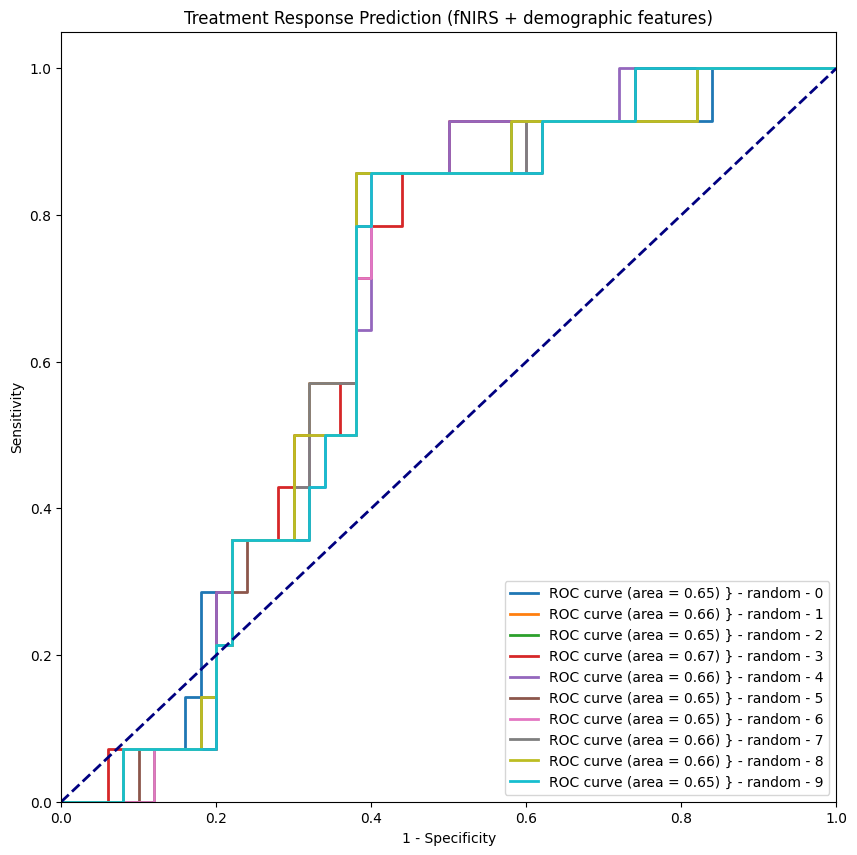

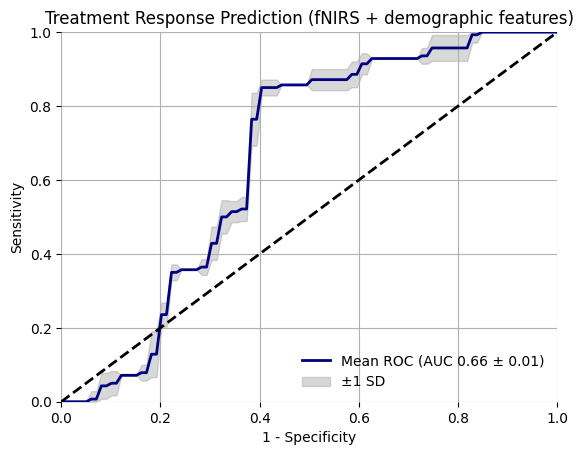

| Model Name | Testing Set |             |             |             | Validation Set |             |             |             |
|------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|
|            | Balanced Accuracy | Sensitivity | Specificity | AUC | Balanced Accuracy | Sensitivity | Specificity | AUC |
| XGBoost   | 57.3714  | 52.1429  | 62.6000  | 65.6000  | 68.8878  | 69.5313  | 68.2444  | 68.8878  |

In [120]:

X_data = np.concatenate((pro_demographic, fnirs_feature), axis=1)
acc = train_xgboost_shuffle_feature(X_data, Y, num_shuffle=10, title="Treatment Response Prediction (fNIRS + demographic features)", is_plotting_avg_auc=True)


/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
TypeError: get_f1_score() takes 2 positional arguments but 3 were given

  warnings.warn(
/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
TypeError: get_f1_score(

outer f1 ->  0.6430403556771546
scaled by 1000000.0 Accuracy: 0.609375 Sensitivity is 0.6428571428571429 Specificity is 0.6 AUC is 0.7000000000000001
[0.64131944 0.65052083 0.63211806]


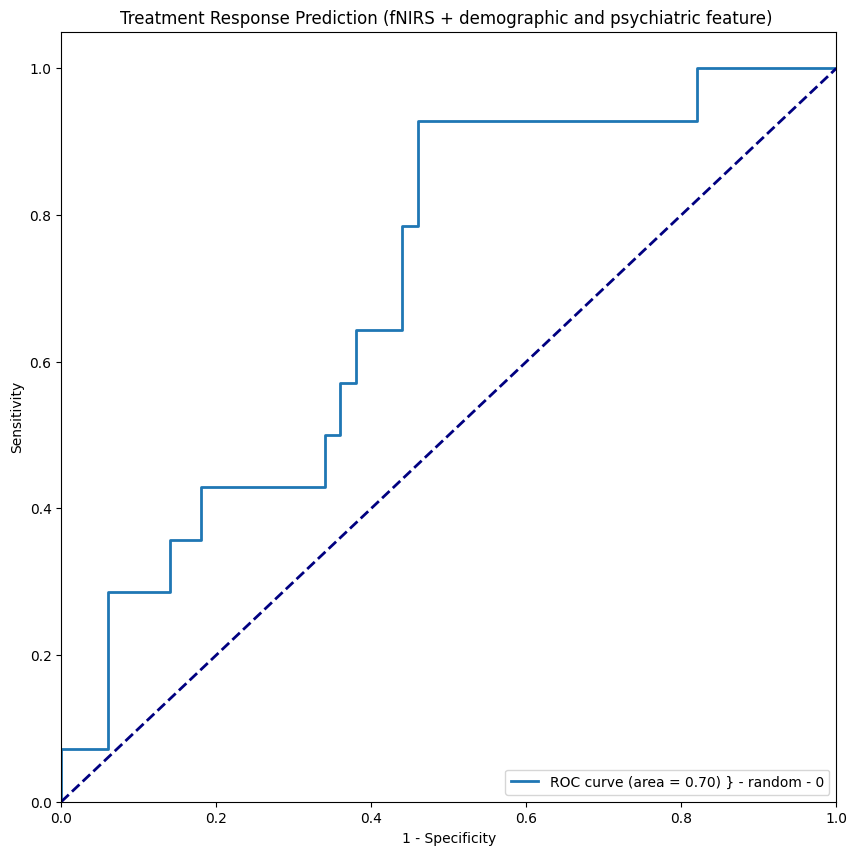

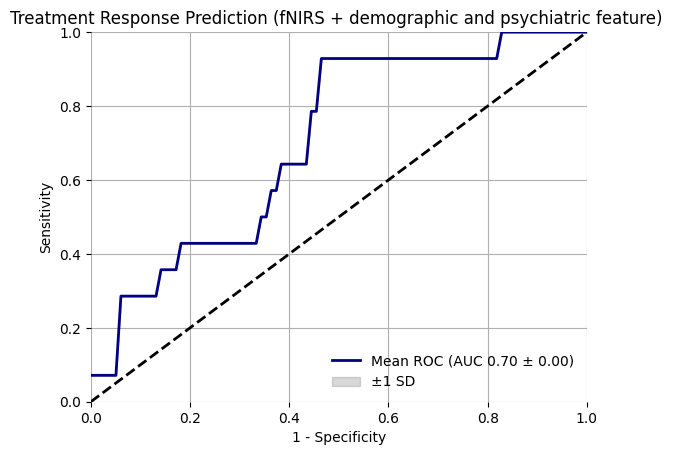

In [104]:
# for i in range(pro_pyschiatry.shape[1]):
X_data = np.concatenate((pro_pyschiatry[:,:9], pro_demographic, fnirs_feature), axis=1)
acc = train_xgboost_shuffle_feature(X_data, Y, num_shuffle=1, title=f"Treatment Response Prediction (fNIRS + demographic and psychiatric feature) ", is_plotting_avg_auc=True)
    



In [ ]:
for i in range(1,pro_pyschiatry.shape[1]+1):
    Y = np.load(fold_path + '/label.npy', allow_pickle=True)
    X_replicated = np.concatenate((pro_pyschiatry[:, :i], 
                        pro_demographic,
                        fnirs_feature
                        ), axis=1)
    train_xgboost_shuffle_feature(X_replicated, Y, num_shuffle=1, msg=f'pyschiatry[:{i}]')

In [8]:
print(z_imputed_clinical_data.shape)
print(demographic_data.shape)
print(fnirs_prediction_all.shape)

X = np.concatenate((z_imputed_clinical_data, demographic_data, fnirs_feature), axis=1)

# np.save(fold_path + '/demo_11_cli_7_fnirs_1.npy', X)

(64, 7)
(64, 11)
(64, 1)


scaled by 1000000.0 Accuracy: 0.671875 Sensitivity is 0.5714285714285714 Specificity is 0.7
[0.71138889 0.78229167 0.64048611]
scaled by 1000000.0 Accuracy: 0.65625 Sensitivity is 0.5 Specificity is 0.7
[0.71475694 0.78385417 0.64565972]


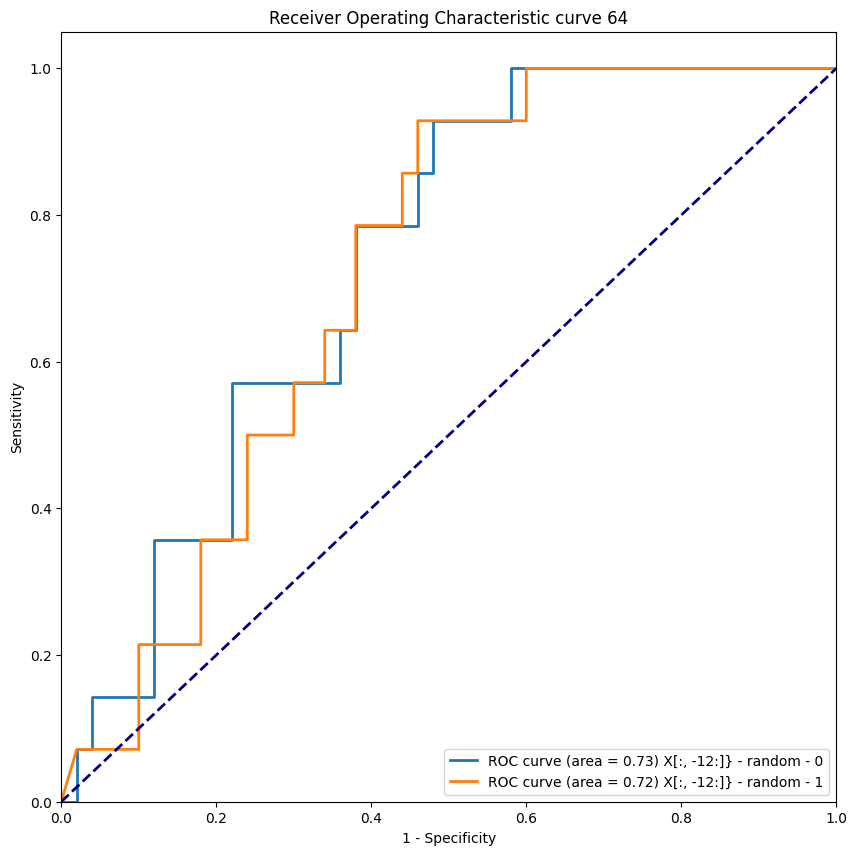

In [361]:
Y = np.load(fold_path + '/label.npy', allow_pickle=True)
feature_i = 11 # for feature_i in range(X.shape[1]):
train_xgboost_shuffle_feature(X[:, -feature_i-1:], Y)

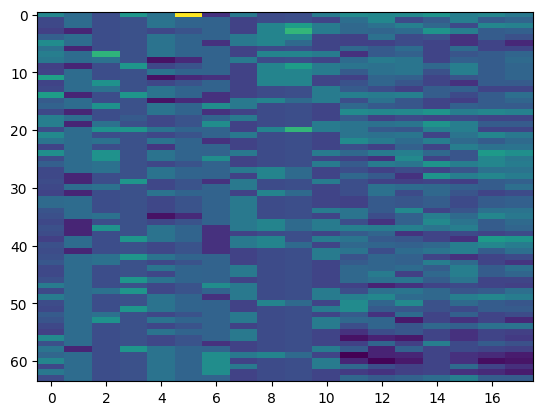

In [14]:
demo_cli_merge_data = np.concatenate((demographic_data, z_imputed_data), axis=1)
import matplotlib.pyplot as plt
plt.imshow(demo_cli_merge_data, aspect='auto')
np.save(fold_path + '/nor_demo_cli_merge_data.npy', demo_cli_merge_data)

In [25]:
combine = list(zip(demo_cli_merge_data, demo_cli_merge_data, demo_cli_merge_data))

import random
random.shuffle(combine)

a, b, c = zip(*combine)
print(a[0])
print(b[0])
print(c[0])


[-0.50490092  0.52915026 -0.60535015  2.19336545  0.81749636  0.24576958
  0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171   0.38460794
  0.72237662  0.89729277 -0.02881123  0.85416682 -0.89567103 -0.84482082]
[-0.50490092  0.52915026 -0.60535015  2.19336545  0.81749636  0.24576958
  0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171   0.38460794
  0.72237662  0.89729277 -0.02881123  0.85416682 -0.89567103 -0.84482082]
[-0.50490092  0.52915026 -0.60535015  2.19336545  0.81749636  0.24576958
  0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171   0.38460794
  0.72237662  0.89729277 -0.02881123  0.85416682 -0.89567103 -0.84482082]


In [24]:


Y_train = np.load(fold_path + '/label.npy', allow_pickle=True)

In [26]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

X_train = X
Y_train = np.load(fold_path + '/label.npy', allow_pickle=True)

# 定义模型
model = CatBoostClassifier(verbose=0)

# 参数网格
param_grid = {
    'learning_rate': [1e-6],
    'depth': [4],
    'l2_leaf_reg': [5],
    'iterations': [100],
    'border_count': [32],


}

# 网格搜索
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# 最佳参数和性能
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


ModuleNotFoundError: No module named 'catboost'

In [38]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


X_train = X
Y_train = np.load(fold_path + '/label.npy', allow_pickle=True)

# 定义模型
model = XGBClassifier(scale_pos_weight=61*1e5)

# 参数网格
# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 500],
    'max_depth': [4],  # Depth of trees. Increasing this value will make the model more complex and more likely to overfit.
    'learning_rate': [0.01],  # Step size shrinkage used to prevent overfitting. Range is [0,1]
    'scale_pos_weight': [1e2],  # A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
}

# 网格搜索
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, Y_train)

# 最佳参数和性能
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50, 'scale_pos_weight': 100.0}
Best score: 1.0


In [30]:
demographic_data = np.load(fold_path + '/demografic_data.npy', allow_pickle=True)
demographic_data = demographic_data.astype(float)
demographic_data = np.nan_to_num(demographic_data, 0)
demographic_data = zscore(demographic_data, axis=0)
print(demographic_data)

[[ 1.54893332  0.52915026 -0.60535015  2.1665957   0.81749636  6.79962494
  -1.51102763  1.03175391 -0.67419986 -0.5400228   1.13389342]
 [-0.77874548  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171 ]
 [-0.77874548  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648  -0.96922337  1.4832397   2.50951771  1.13389342]
 [-1.05259005 -1.88982237 -0.60535015 -0.42521972 -0.80064077 -0.40961596
   0.1855648  -0.96922337  1.4832397   3.52603121  1.13389342]
 [ 0.04278821  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648   1.03175391  1.4832397   1.4930042  -0.8819171 ]
 [ 1.82277789  0.52915026 -0.60535015 -0.42521972  0.81749636  0.24576958
  -1.51102763  1.03175391  1.4832397   0.4764907  -0.8819171 ]
 [ 0.72739963 -1.88982237 -0.60535015 -0.42521972  0.81749636  0.24576958
   0.1855648  -0.96922337 -0.67419986 -0.5400228  -0.8819171 ]
 [ 1.27508876  0.52915026  3.40248531 -0.

model - CatBoost - metrics - {'bAcc': 0.6633333333333333, 'Sensitivity': 0.6666666666666666, 'Specificity': 0.6599999999999999}
model - XGBoost - metrics - {'bAcc': 0.6466666666666667, 'Sensitivity': 0.7333333333333333, 'Specificity': 0.5599999999999999}
model - RandomForest - metrics - {'bAcc': 0.6166666666666666, 'Sensitivity': 0.4333333333333333, 'Specificity': 0.8}
model - DecisionTree - metrics - {'bAcc': 0.5733333333333333, 'Sensitivity': 0.36666666666666664, 'Specificity': 0.78}
model - Support Vector - metrics - {'bAcc': 0.5, 'Sensitivity': 0.0, 'Specificity': 1.0}
model - NearestNeighbor - metrics - {'bAcc': 0.49000000000000005, 'Sensitivity': 0.0, 'Specificity': 0.9800000000000001}
model - Perceptron - metrics - {'bAcc': 0.48999999999999994, 'Sensitivity': 0.3, 'Specificity': 0.6799999999999999}


In [208]:
X.shape

8 - > 3 ->  7 1 

(64, 19)

scaled by 1000000.0 Accuracy: 0.671875 Sensitivity is 0.5714285714285714 Specificity is 0.7
[0.70984375 0.78125    0.6384375 ]
scaled by 1000000.0 Accuracy: 0.671875 Sensitivity is 0.5714285714285714 Specificity is 0.7
[0.71489583 0.78541667 0.644375  ]


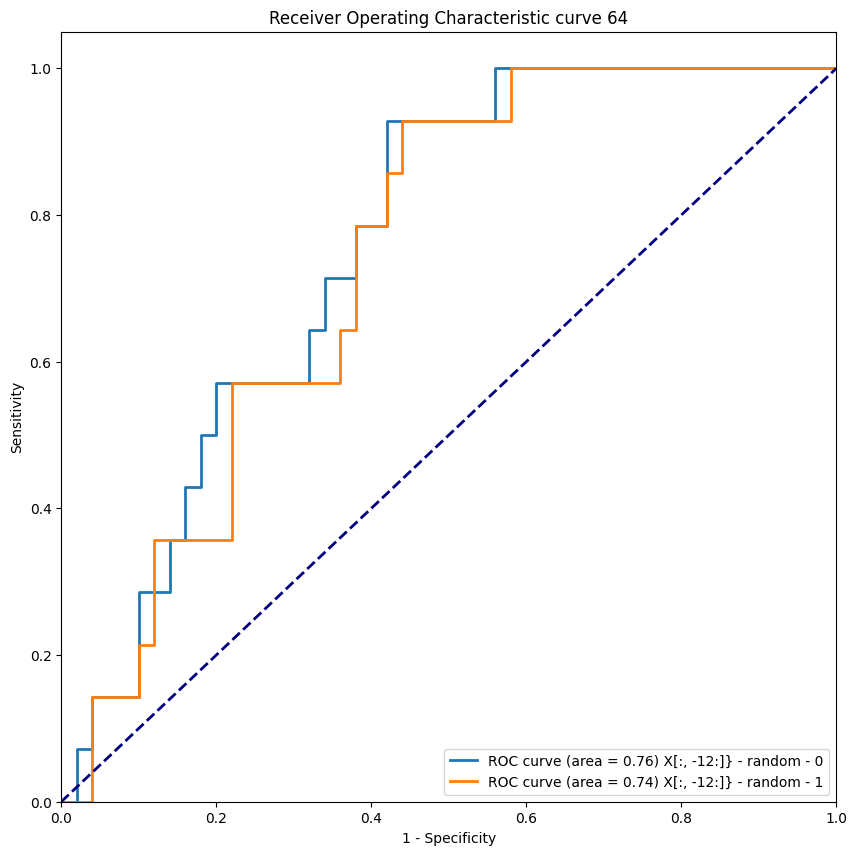

In [11]:
from sklearn.model_selection import LeaveOneOut, cross_validate, KFold, cross_val_predict
from sklearn.metrics import make_scorer, balanced_accuracy_score, recall_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import numpy as np



    
Y = np.load(fold_path + '/label.npy', allow_pickle=True)
feature_i = 11 # for feature_i in range(X.shape[1]):
train_xgboost_shuffle_feature(X[:, -feature_i-1:], Y)

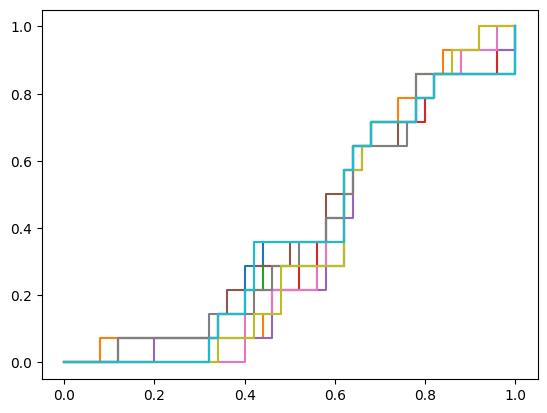

In [198]:
for i in all_fpr_tpr:
    plt.plot(i[0], i[1])

In [199]:
fprs = []
tprs = []
roc_aucs = []
for i in all_fpr_tpr:
    fprs.append(i[0])
    tprs.append(i[1])
    roc_aucs.append(auc(i[0], i[1]))

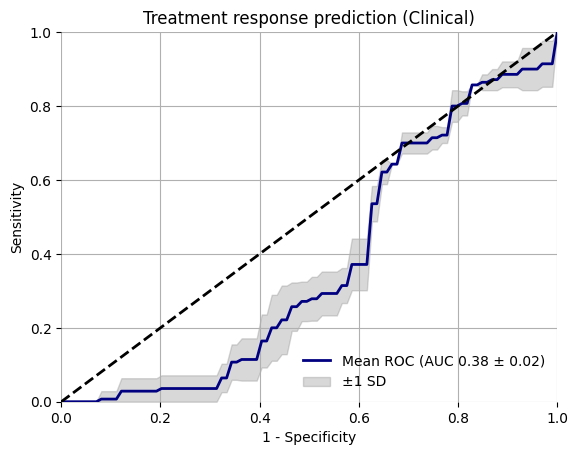

In [201]:

from scipy import interp





# plt.plot(mean_fpr, mean_tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

In [1]:
import matplotlib.pyplot as plt
fusion_data[:,-1:]

last_fusion_data = fusion_data[:,-1:].copy()
pos_las = last_fusion_data[Y_train == 1]
neg_las = last_fusion_data[Y_train == 0]
plt.hist(pos_las, bins=20, alpha=0.5, label='Positive')

plt.figure()
plt.hist(neg_las, bins=20, alpha=0.5, label='Negative')

NameError: name 'fusion_data' is not defined